#  Прогнозирование заказов такси

### Описание задачи:


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Цель:

Протестировать и подобрать оптимальную модель для прогнозирования количества заказов такси в будущий час.

## Подготовка

In [1]:
# импорт Pandas
import pandas as pd

# импорт Os для работы с файлами и каталогами
import os

# импорт Numpy
import numpy as np

import datetime

# импорт matplotlib для управления графиками
import matplotlib.pyplot as plt

# импорт Sklearn

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# импорт Catboost

from catboost import CatBoostRegressor

# импорт LightGBM

from lightgbm import LGBMRegressor

# импорт Seasonal

from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# напишем функцию для комфортной загрузки датасетов и локально, и с сервера

def file_loader(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Check the path')

In [3]:
df = file_loader('taxi.csv', '/datasets/taxi.csv')

In [4]:
df.head(15)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df['datetime'] = df['datetime'].astype('datetime64')
df = df.set_index('datetime')

In [7]:
df.describe()

,num_orders
count,"26,496.00"
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


In [8]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


#### Вывод:

Данные в хорошем состоянии и готовы для анализа и последующих операций

## Анализ

Посмотрим на график распределения заказов по времени.

<AxesSubplot:xlabel='datetime'>

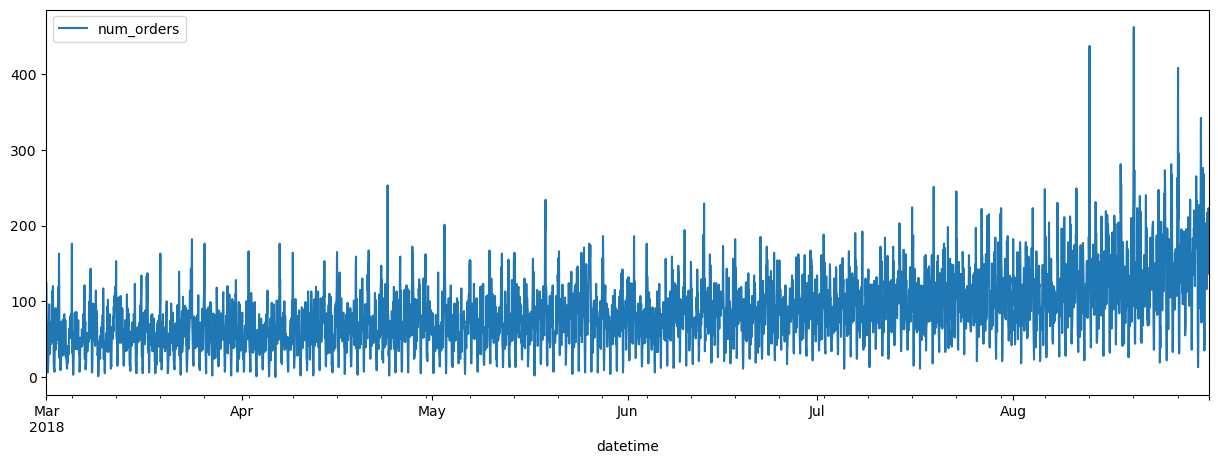

In [9]:
df.plot(figsize=(15, 5))

Из данного график сложно сделать какие-либо выводы, кроме того, что количество заказов такси сильно колеблется в течении времени, а также, что количество заказов в час к концу лета увеличилось<br/>

Для выявления закономерностей произведем декомпозицию.

<AxesSubplot:xlabel='datetime'>

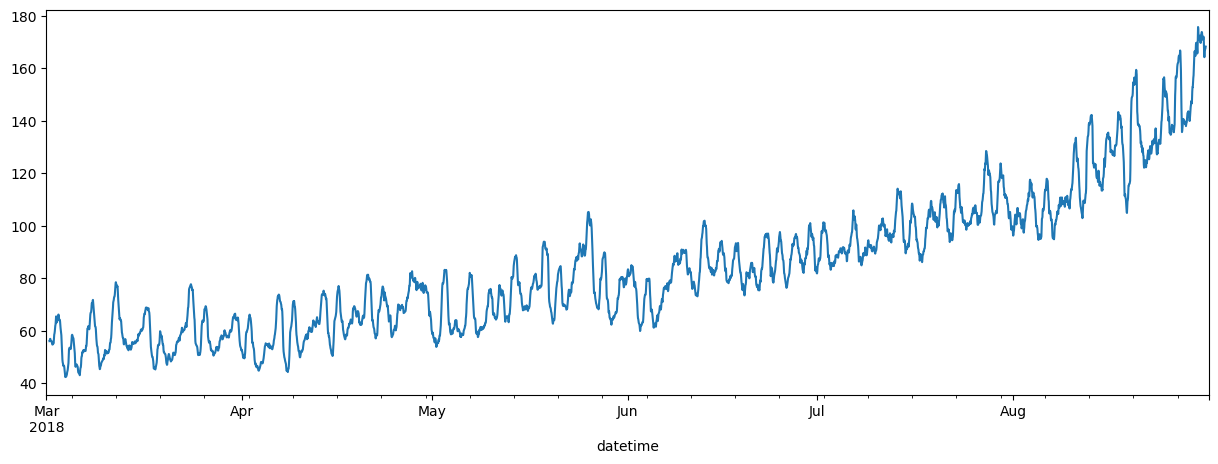

In [10]:
df_decomposed = seasonal_decompose(df)
df_decomposed.trend.plot(figsize=(15, 5))

Из графика тренда можно сделать однозначный вывод, что ежечасное количество заказов у данного оператора такси на протяжении всего анализируемого периода времени растет. Это говорит о росте популярности данного сервиса и стабильном развитии бизнеса. <br/>
Также данный рост может быть связан с сезонными явлениями годового масштаба (например, весной заказов меньше чем летом, а пик наблюдается в сентябре, а потом все опять снижается к зиме). Но для проверки данной гипотезы нам не хватает данных - нужны данные хотя бы за 2 года.
<br/>
Также в колебаниях графика в течение месяца можно увидеть некую повторяемость. На ежедневные колебания они не похожи, возможно есть некая зависимость количества заказов от дня недели. Проверим эту гипотезу чуть позже.
<br/>
Рост продаж подтверждает и график скользящей средней.

<AxesSubplot:xlabel='datetime'>

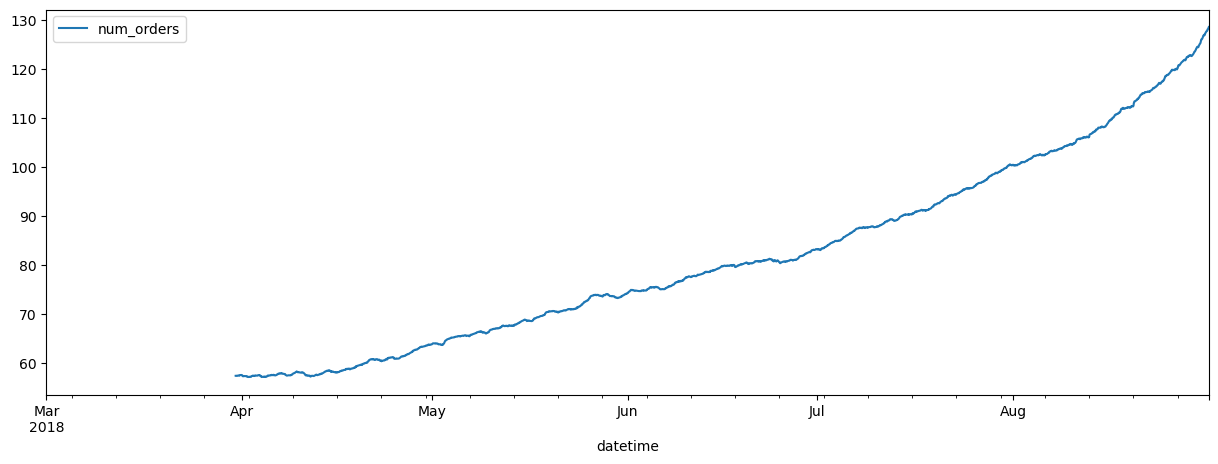

In [11]:
# месячное усреднение
df.rolling(720).mean().plot(figsize=(15, 5))

Видим, что среднемесячное количество заказов в час за анализируемый период выросло более чем в 2 раза.

<AxesSubplot:xlabel='datetime'>

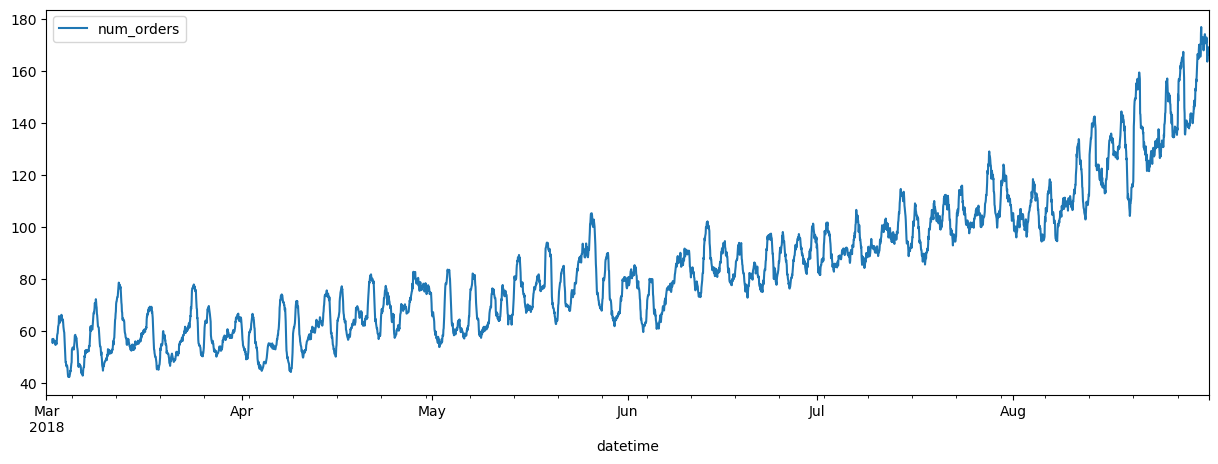

In [12]:
# месячное усреднение
df.rolling(24).mean().plot(figsize=(15, 5))

Среднедневное количество заказов колеблется сильнее.<br/>

Проанализируем колебания и попытаемся найти в них закономерности.

<AxesSubplot:xlabel='datetime'>

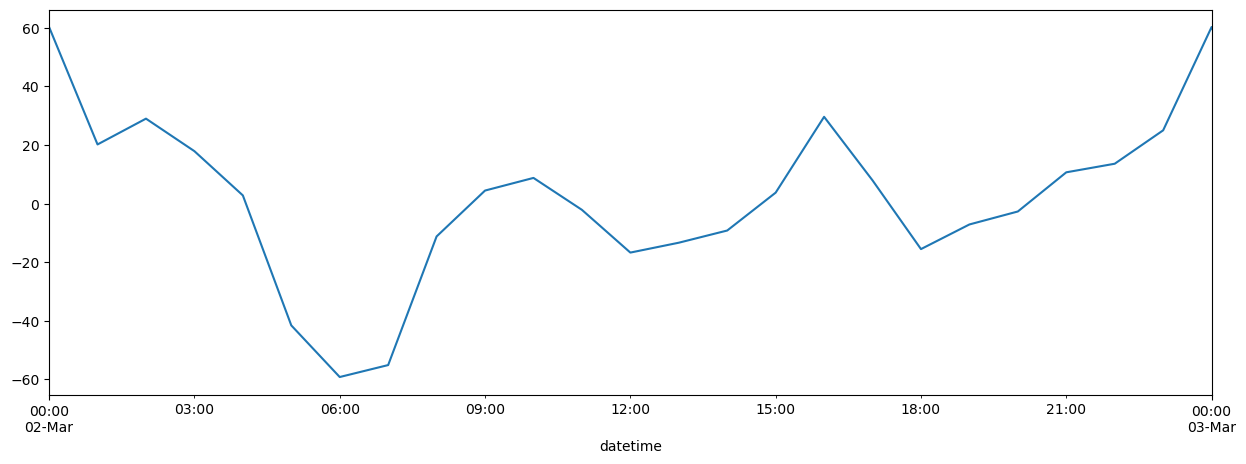

In [13]:
df_decomposed.seasonal.plot(figsize=(15, 5), xlim=('2018-03-02', '2018-03-03'))

Видим четкие колебания количества заказов в течение суток: наименьшее количество заказов с 4 до 8 утра, пик заказов приходится на период с 23.00 до 01.00. Такие колебания обусловлены тем, что люди предпочитают ночью спать. И если даже рейс ночью, они предпочитают выехать на него заранее, и поспать в аэропорте.

<AxesSubplot:xlabel='datetime'>

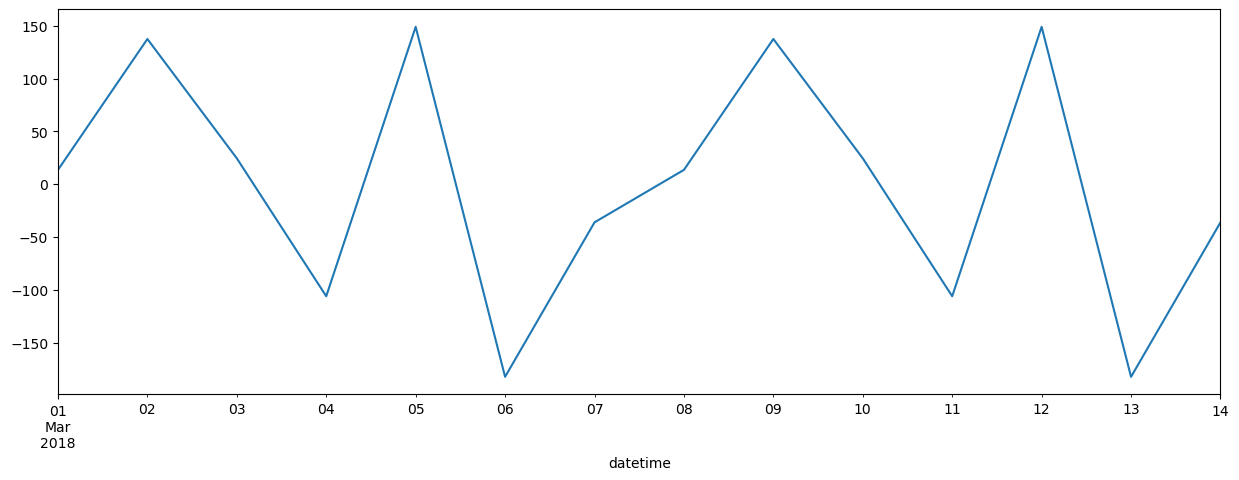

In [14]:
df_by_days = df.resample('1D').sum()
df_bd_dec = seasonal_decompose(df_by_days)
df_bd_dec.seasonal.plot(figsize=(15, 5), xlim=('2018-03-01', '2018-03-14'))

На графике за период в 14 дней хорошо видно, что сезонность имеет период в 7 дней и очевидно зависит от дня недели. Однако из этого графика непонятно, в какие именно дни недели происходят те или иные колебания спроса на услуги такси. Построим для этого другой график.

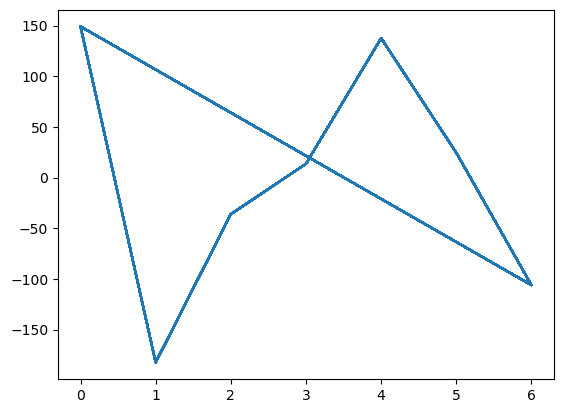

In [15]:
plt.plot(df_by_days.index.dayofweek, df_bd_dec.seasonal);

Из графика видно, что наибольший спрос на такси в Воскресенье (0) и Четверг (4), а наименьший в Понедельник и Субботу, причем колебания довольно существенные.

<AxesSubplot:xlabel='datetime'>

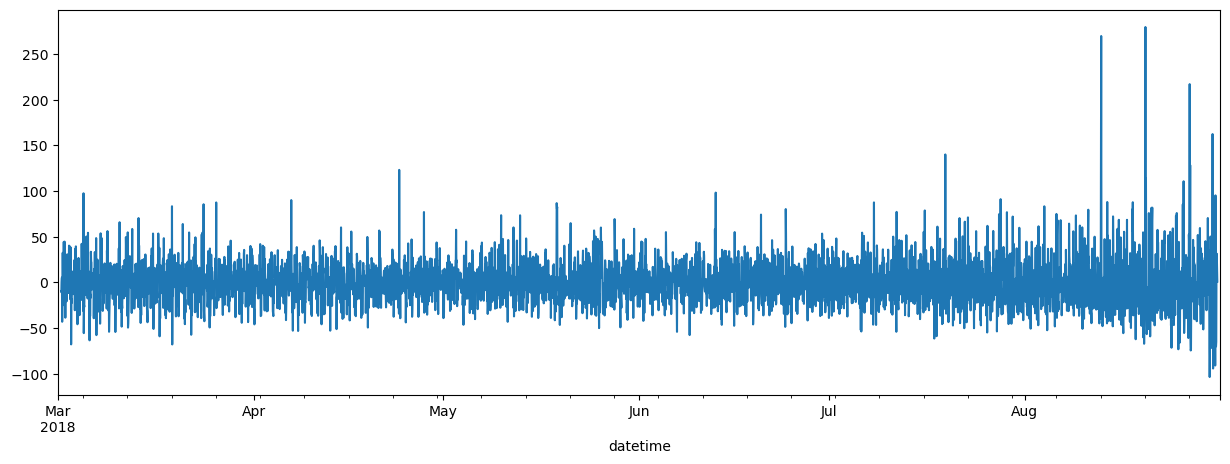

In [16]:
df_decomposed.resid.plot(figsize=(15, 5))

На графике с шумами видим некоторое количество больших пиков в положительную стороны, что говорит о наличии случайных факторов, влияющих на количество заказов (например, международная выставка или чемпионат по футболу).

#### Вывод:

В исторических данных по заказам такси имеется четкая сезонная зависимость от времени суток и дня недели. Также имеется четкий тренд на увеличение заказов от месяца к месяцу. В данных присутствует определенное количество шумов, которые могут объясняться влиением случайных факторов.

## Обучение

Чтобы было чему обучать моделей), создадим для них признаки. 

In [17]:
# добавим календарные признаки

df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df

,num_orders,day,hour,dayofweek,month
datetime,,,,,
2018-03-01 00:00:00,124,1,0,3,3
2018-03-01 01:00:00,85,1,1,3,3
2018-03-01 02:00:00,71,1,2,3,3
2018-03-01 03:00:00,66,1,3,3,3
2018-03-01 04:00:00,43,1,4,3,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,31,19,4,8
2018-08-31 20:00:00,154,31,20,4,8
2018-08-31 21:00:00,159,31,21,4,8


In [18]:
# добавим отстающие значения (lag)

n = 3
for i in range(1, n+1):
    name = 'lag_' + str(i)
    df[name] = df['num_orders'].shift(i, fill_value=0)
df

,num_orders,day,hour,dayofweek,month,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,3,0,0,0
2018-03-01 01:00:00,85,1,1,3,3,124,0,0
2018-03-01 02:00:00,71,1,2,3,3,85,124,0
2018-03-01 03:00:00,66,1,3,3,3,71,85,124
2018-03-01 04:00:00,43,1,4,3,3,66,71,85
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,19,4,8,207,217,197
2018-08-31 20:00:00,154,31,20,4,8,136,207,217
2018-08-31 21:00:00,159,31,21,4,8,154,136,207


In [19]:
# добавим скользящую среднюю

window = 3
df['rolling_mean'] = df['num_orders'].shift().rolling(window, min_periods=0).mean()
df = df.drop('2018-03-01 00:00:00')
df

,num_orders,day,hour,dayofweek,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 01:00:00,85,1,1,3,3,124,0,0,124.00
2018-03-01 02:00:00,71,1,2,3,3,85,124,0,104.50
2018-03-01 03:00:00,66,1,3,3,3,71,85,124,93.33
2018-03-01 04:00:00,43,1,4,3,3,66,71,85,74.00
2018-03-01 05:00:00,6,1,5,3,3,43,66,71,60.00
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,19,4,8,207,217,197,207.00
2018-08-31 20:00:00,154,31,20,4,8,136,207,217,186.67
2018-08-31 21:00:00,159,31,21,4,8,154,136,207,165.67


In [20]:
# выделим целевой признак и признаки

features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [21]:
# разделим на обучающую и тестовую выборки

train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.1)
train_features


,day,hour,dayofweek,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 01:00:00,1,1,3,3,124,0,0,124.00
2018-03-01 02:00:00,1,2,3,3,85,124,0,104.50
2018-03-01 03:00:00,1,3,3,3,71,85,124,93.33
2018-03-01 04:00:00,1,4,3,3,66,71,85,74.00
2018-03-01 05:00:00,1,5,3,3,43,66,71,60.00
...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,13,9,0,8,91,39,66,65.33
2018-08-13 10:00:00,13,10,0,8,137,91,39,89.00
2018-08-13 11:00:00,13,11,0,8,156,137,91,128.00


Обучим известные нам модели и подберем оптимальные гиперпараметры


1. Решающее дерево


In [22]:
%%time

# используем RandomizedSearchCV для подбора параметров заменив в нем стандартный кросс-валидационный сплитер
# на специальный для временных рядов

tscv = TimeSeriesSplit()

model = DecisionTreeRegressor(random_state=1982)
depth_range = list(range(1, 31))
params = {'max_depth': depth_range}
tree_model = RandomizedSearchCV(model, params, scoring='neg_root_mean_squared_error', verbose=1, cv=tscv, random_state=1982)
tree_model.fit(train_features, train_target)
tree_best_params = tree_model.best_params_
tree_best_params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 426 ms


{'max_depth': 8}

In [23]:
tree_model = DecisionTreeRegressor(**tree_best_params, random_state=1982)

2. Случайный лес


In [24]:
%%time

model = RandomForestRegressor(random_state=1982)
depth_range = list(range(1, 21))
est_range = list(range(1, 11))
params = {'max_depth': depth_range, 'n_estimators': est_range}
rf_model = RandomizedSearchCV(model, params, scoring='neg_root_mean_squared_error', verbose=1, cv=tscv, random_state=1982)
rf_model.fit(train_features, train_target)
rf_best_params = rf_model.best_params_
rf_best_params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1.07 s


{'n_estimators': 10, 'max_depth': 16}

In [25]:
rf_model = RandomForestRegressor(**rf_best_params, random_state=1982)

3. Линейная регрессия


In [26]:
lr_model = LinearRegression()

4. Catboost


In [27]:
%%time

cb_model = CatBoostRegressor(random_state=1982, verbose=0)
depth_range = list(range(1, 11))
params = {'learning_rate': [0.03, 0.1, 0.5],
          'depth': depth_range,
          'iterations': [10, 100],
          'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cb_model.grid_search(params, X=train_features, y=train_target, cv=tscv, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 95.95788303
bestIteration = 9

0:	loss: 95.9578830	best: 95.9578830 (0)	total: 174ms	remaining: 52.2s

bestTest = 68.70808775
bestIteration = 9

1:	loss: 68.7080877	best: 68.7080877 (1)	total: 186ms	remaining: 27.6s

bestTest = 43.04217675
bestIteration = 9

2:	loss: 43.0421767	best: 43.0421767 (2)	total: 247ms	remaining: 24.4s

bestTest = 95.98173302
bestIteration = 9

3:	loss: 95.9817330	best: 43.0421767 (2)	total: 294ms	remaining: 21.8s

bestTest = 68.7454317
bestIteration = 9

4:	loss: 68.7454317	best: 43.0421767 (2)	total: 331ms	remaining: 19.5s

bestTest = 43.06949794
bestIteration = 9

5:	loss: 43.0694979	best: 43.0421767 (2)	total: 374ms	remaining: 18.3s

bestTest = 96.00547136
bestIteration = 9

6:	loss: 96.0054714	best: 43.0421767 (2)	total: 395ms	remaining: 16.5s

bestTest = 68.78252601
bestIteration = 9

7:	loss: 68.7825260	best: 43.0421767 (2)	total: 431ms	remaining: 15.7s

bestTest = 43.09679194
bestIteration = 9

8:	loss: 43.0967919	best: 43.0421767 (2)	total


bestTest = 94.71701863
bestIteration = 9

72:	loss: 94.7170186	best: 31.0260124 (47)	total: 10.6s	remaining: 32.9s

bestTest = 65.92054606
bestIteration = 9

73:	loss: 65.9205461	best: 31.0260124 (47)	total: 10.6s	remaining: 32.3s

bestTest = 37.41582656
bestIteration = 9

74:	loss: 37.4158266	best: 31.0260124 (47)	total: 10.6s	remaining: 31.8s

bestTest = 42.08309801
bestIteration = 99

75:	loss: 42.0830980	best: 31.0260124 (47)	total: 11s	remaining: 32.4s

bestTest = 32.9775695
bestIteration = 99

76:	loss: 32.9775695	best: 31.0260124 (47)	total: 11.2s	remaining: 32.3s

bestTest = 31.35259806
bestIteration = 79

77:	loss: 31.3525981	best: 31.0260124 (47)	total: 11.8s	remaining: 33.6s

bestTest = 42.1487633
bestIteration = 99

78:	loss: 42.1487633	best: 31.0260124 (47)	total: 12.2s	remaining: 34.3s

bestTest = 33.08316097
bestIteration = 99

79:	loss: 33.0831610	best: 31.0260124 (47)	total: 12.4s	remaining: 34s

bestTest = 30.16449191
bestIteration = 94

80:	loss: 30.1644919	best: 30


bestTest = 32.82284868
bestIteration = 75

143:	loss: 32.8228487	best: 30.1644919 (80)	total: 34.7s	remaining: 37.5s

bestTest = 41.14560089
bestIteration = 99

144:	loss: 41.1456009	best: 30.1644919 (80)	total: 35.5s	remaining: 37.9s

bestTest = 33.16243866
bestIteration = 99

145:	loss: 33.1624387	best: 30.1644919 (80)	total: 36.4s	remaining: 38.4s

bestTest = 31.61612568
bestIteration = 94

146:	loss: 31.6161257	best: 30.1644919 (80)	total: 37.2s	remaining: 38.7s

bestTest = 41.63724543
bestIteration = 99

147:	loss: 41.6372454	best: 30.1644919 (80)	total: 38.1s	remaining: 39.1s

bestTest = 33.5282923
bestIteration = 99

148:	loss: 33.5282923	best: 30.1644919 (80)	total: 39s	remaining: 39.5s

bestTest = 33.23928474
bestIteration = 74

149:	loss: 33.2392847	best: 30.1644919 (80)	total: 39.9s	remaining: 39.9s

bestTest = 93.84772317
bestIteration = 9

150:	loss: 93.8477232	best: 30.1644919 (80)	total: 40s	remaining: 39.4s

bestTest = 63.70228903
bestIteration = 9

151:	loss: 63.70228


bestTest = 95.43841974
bestIteration = 9

213:	loss: 95.4384197	best: 30.1644919 (80)	total: 1m 17s	remaining: 31.1s

bestTest = 65.34247078
bestIteration = 9

214:	loss: 65.3424708	best: 30.1644919 (80)	total: 1m 17s	remaining: 30.6s

bestTest = 35.05463063
bestIteration = 9

215:	loss: 35.0546306	best: 30.1644919 (80)	total: 1m 17s	remaining: 30.2s

bestTest = 96.12512076
bestIteration = 9

216:	loss: 96.1251208	best: 30.1644919 (80)	total: 1m 17s	remaining: 29.8s

bestTest = 66.33799395
bestIteration = 9

217:	loss: 66.3379940	best: 30.1644919 (80)	total: 1m 17s	remaining: 29.3s

bestTest = 36.67614728
bestIteration = 9

218:	loss: 36.6761473	best: 30.1644919 (80)	total: 1m 18s	remaining: 28.9s

bestTest = 96.60016119
bestIteration = 9

219:	loss: 96.6001612	best: 30.1644919 (80)	total: 1m 18s	remaining: 28.5s

bestTest = 67.53340626
bestIteration = 9

220:	loss: 67.5334063	best: 30.1644919 (80)	total: 1m 18s	remaining: 28s

bestTest = 36.72384561
bestIteration = 9

221:	loss: 36.7


bestTest = 71.6667703
bestIteration = 9

283:	loss: 71.6667703	best: 30.1644919 (80)	total: 2m 20s	remaining: 7.9s

bestTest = 43.73783941
bestIteration = 9

284:	loss: 43.7378394	best: 30.1644919 (80)	total: 2m 20s	remaining: 7.39s

bestTest = 42.74132368
bestIteration = 99

285:	loss: 42.7413237	best: 30.1644919 (80)	total: 2m 22s	remaining: 6.99s

bestTest = 36.41584993
bestIteration = 98

286:	loss: 36.4158499	best: 30.1644919 (80)	total: 2m 25s	remaining: 6.59s

bestTest = 38.15626682
bestIteration = 28

287:	loss: 38.1562668	best: 30.1644919 (80)	total: 2m 28s	remaining: 6.17s

bestTest = 43.76997691
bestIteration = 99

288:	loss: 43.7699769	best: 30.1644919 (80)	total: 2m 30s	remaining: 5.72s

bestTest = 36.81275149
bestIteration = 99

289:	loss: 36.8127515	best: 30.1644919 (80)	total: 2m 32s	remaining: 5.27s

bestTest = 35.7277692
bestIteration = 41

290:	loss: 35.7277692	best: 30.1644919 (80)	total: 2m 35s	remaining: 4.81s

bestTest = 45.46385809
bestIteration = 99

291:	loss

In [28]:
cb_model = CatBoostRegressor(**grid_search_result['params'], random_state=1982, verbose=0)

5. LightGBM


In [29]:
%%time

model = LGBMRegressor(random_state=1982)
depth_range = list(range(1, 21))
est_range = [1, 3, 5, 10, 20, 100, 500, 1000]
speed_range = [0.03, 0.1, 0.5, 0.7, 1]
params = {'max_depth': depth_range, 'n_estimators': est_range, 'learning_rate': speed_range}
lgbm_model = RandomizedSearchCV(model, params, scoring='neg_root_mean_squared_error', verbose=1, cv=tscv, random_state=1982)
lgbm_model.fit(train_features, train_target)
lgbm_best_params1 = lgbm_model.best_params_
lgbm_best_params1

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 52.5 s


{'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.1}

In [30]:
lgbm_model = LGBMRegressor(**lgbm_best_params1, random_state=1982)

## Тестирование

In [31]:
def model_fit(model):
    model.fit(train_features, train_target)
    

In [32]:
def model_test(model):
    test_predictions = model.predict(test_features)
    rmse = mean_squared_error(test_target, test_predictions, squared=False)
    return rmse

In [33]:
pd.set_option('max_colwidth', 120)

models = [tree_model, rf_model, lr_model, cb_model, lgbm_model]
results = []
for model in models:
    row = []
    l_time = %timeit -n1 -r1 -o model_fit(model);
    p_time = %timeit -n1 -r1 -o model_test(model);
    rmse = model_test(model)
    row.append(str(model))
    row.append(rmse)
    row.append(str(l_time)[:7])
    row.append(str(p_time)[:7])
    results.append(row)
results = pd.DataFrame(results, columns=['Model', 'RMSE', 'Learning_time', 'Predicting_time'])
results

15.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
144 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.74 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
84.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.79 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
131 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
401 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,Model,RMSE,Learning_time,Predicting_time
0,"DecisionTreeRegressor(max_depth=8, random_state=1982)",56.11,15.7 ms,2.11 ms
1,"RandomForestRegressor(max_depth=16, n_estimators=10, random_state=1982)",49.83,144 ms,2.74 ms
2,LinearRegression(),52.43,84.2 ms,1.79 ms
3,<catboost.core.CatBoostRegressor object at 0x000001995E559160>,45.57,131 ms,1.65 ms
4,"LGBMRegressor(max_depth=16, random_state=1982)",42.96,401 ms,2.66 ms


## Общий вывод

В результате иследования эффективности работы различных моделей можно сделать ряд выводов:
* Наибольшую эффективность показывают модели бустинга. Остальные модели не смогли преодолеть порог в 48.
* Наилучший показатель RMSE у модели LGBM, скорость обучения существенно выше чем у Catboost, однако по скорости предсказания выигрывает последний.
* В ходе подбора параметров и последующих промежуточных тестирований было обнаружено, что при повышении количества отстающих признаков (lag) качество работы Случайного леса повышается и он преодолевает порог, а моделей бустинга незначительно снижается.

* Catboost характеризуется повышенным временем подбора оптимальных гиперпараметров при использовании встроенного инструмента подбора

Для предсказания спроса (количества заказов) на услуги такси на основании исторических данных мы рекомендуем использовать модель LGBM, как наиболее результативную (RMSE=43).